# Stats Descriptives

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from geopy.distance import vincenty

In [2]:
# load train and test data
df_mess_train = pd.read_csv('../data/mess_train_list.csv')
df_mess_test = pd.read_csv('../data/mess_test_list.csv')
pos_train = pd.read_csv('../data/pos_train_list.csv')
pred_pos_test = pd.read_csv('../data/pred_pos_test_list.csv')

In [3]:
df_mess_train.head()

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


## Plot density

### Plot RSSI density
> **rssi**: puissance du signal lors de la réception.

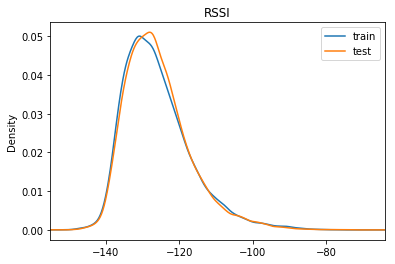

In [4]:
min_rssi = df_mess_train.rssi.min()
max_rssi = df_mess_train.rssi.max()

df_mess_train.rssi.plot.density(label="train")
df_mess_test.rssi.plot.density(label="test")


plt.xlim(min_rssi, max_rssi)
plt.title("RSSI")
plt.legend()
plt.show()

> **rssi**: On a les mêmes densité pour les train et test sets. (cf rapport)

### Plot Nseq density
> **nseq**: fréquence à laquelle les messages sont envoyés (contient peu d'info)

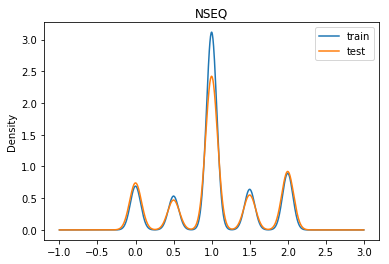

In [5]:
df_mess_train.nseq.plot.density(label="train")
df_mess_test.nseq.plot.density(label="test")

plt.title("NSEQ")
plt.legend()
plt.show()

> Globalement on a les mêmes densités entre le train et le test set pour la variable **nseq**.

## Plot Map

In [6]:
import folium

On réalise des listes qui contiennent les coordonnées des bases.

In [7]:
LAT_LONG_BASE = set(zip(df_mess_train.bs_lat, df_mess_train.bs_lng, df_mess_train.bsid))
LAT_LONG_OBJ = list(set(zip(pos_train.lat, pos_train.lng)))
LAT_LONG_PRED = list(set(zip(pred_pos_test.lat, pred_pos_test.lng)))
LAT_LONG_TEST = set(zip(df_mess_test.bs_lat, df_mess_test.bs_lng, df_mess_test.bsid))

On regarde si toutes les bases du **training set** sont aussi présentes dans le **test set**:

In [8]:
unique_bsid_train = set(df_mess_train.bsid)
unique_bsid_test = set(df_mess_test.bsid)

bsid_in_train_not_in_test = LAT_LONG_BASE.difference(LAT_LONG_TEST)
bsid_in_test_not_in_train = LAT_LONG_TEST.difference(LAT_LONG_BASE)
shared_bsid = set.intersection(LAT_LONG_BASE, LAT_LONG_TEST)

On affiche la map:
* en **bleu marine** on affiche les bases partagées par les deux **sets** (training et test). 
* en **orange** on affiche les stations uniquement dans le **test set**.
* en **cyan** on affiche les stations uniquement dans le **training set**.

In [9]:
map_osm = folium.Map(location=[40, -103], zoom_start=6, tiles='Stamen Terrain')
count = 0
far_bsids = []

for lat, long, bsid in bsid_in_train_not_in_test:
    folium.RegularPolygonMarker([lat, long], popup='base ' + str(bsid),
                                fill_color='cyan', number_of_sides=8, radius=7).add_to(map_osm)

for lat, long, bsid in bsid_in_test_not_in_train:
    folium.RegularPolygonMarker([lat, long], popup='base ' + str(bsid),
                                fill_color='orange', number_of_sides=8, radius=7).add_to(map_osm)

for lat, long, bsid in shared_bsid:
    folium.RegularPolygonMarker([lat, long], popup='base ' + str(bsid),
                                fill_color='blue', number_of_sides=8, radius=7).add_to(map_osm)

path = '/tmp/my_map.html'
map_osm.save(path)

# map_osm

> On voit que les bases de mesure sont majoritairement alignées. Certaines sont plutôt excentrées avec notation une occurence au Canada. On a pris la décision de laisser ces stations assez excentrées lors de l'entraînement des algorithmes car nous n'avions pas de connaissances sur le **test set**. Elles auraient pu être ignorées si on avait eu la certitude que les points du **test set** étaient localisés dans la *ligne* de capteurs.